# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import scipy
from tqdm import tqdm
from matplotlib.lines import Line2D

from qscaled.wandb_utils.one_seed_per_run import ExampleOneSeedPerRunCollector
from qscaled.utils.create_zip import save_loop
from qscaled.core.preprocessing import select_middle_bs_lr, bootstrap_crossings
from qscaled.utils.load_from_zip import UTDGroupedLoader, FullGroupedLoaderUnlabeled

np.random.seed(42)

ModuleNotFoundError: No module named 'qscaled.utils.create_zip'

To use this code:
* Label your Wandb runs with tags
* Update the following three cells

If you already have a zip file (either the data we have cached or data you have
constructed yourself), you can set `wandb_collect = False`, which will skip the 
`BaseCollector`-related cells. Otherwise, you will need to have a `BaseCollector`.

In [ ]:
sweep_path = 'sweep'  # same as in analyze_grid_search.ipynb
ours_path = 'ours'  # name of your cached BaseCollector and zip file
baseline_path = 'baseline_utd2'
logging_freq = 1000  # Wandb logging frequency in steps

# Maximum possible returns (estimated with infinite data and compute) on each
# environment. These are mostly eyeballed such that runs reach 80% (hence
# the 1.25 multiplier) but not 90%. There is considerable variation for different environments.
max_returns = {
    'HalfCheetah-v4': 7300 * 1.25,
    'Walker2d-v4': 4000 * 1.25,
    'Ant-v4': 5300 * 1.25,
    'Humanoid-v4': 5200 * 1.25,
}
model_size = 1.5e5  # number of critic parameters

# thresholds = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]  # out of 1000
thresholds = [200, 300, 400, 500, 600, 700, 800]

wandb_collect = True
assert wandb_collect or all(
    os.path.exists(f'data/zip/{ours_path}.zip'),
    os.path.exists(f'data/zip/{baseline_path}.zip'),
)

In [ ]:
if wandb_collect:
    gym_collector_cls = OneSeedPerRunCollector
    gym_wandb_entity = 'prestonfu'
    gym_wandb_project = 'crl'
    gym_wandb_tags_ours = ['sac_optimal_250210']
    gym_wandb_tags_baseline = ['sac_grid_250207_bl_utd2.0']

    gym_ours_collector = gym_collector_cls(gym_wandb_entity, gym_wandb_project, wandb_tags=gym_wandb_tags_ours)

    gym_baseline_collector = gym_collector_cls(gym_wandb_entity, gym_wandb_project, wandb_tags=gym_wandb_tags_baseline)

    # Drop runs that do not go for the full number of steps and extra runs beyond desired number of seeds
    num_seeds = 8
    gym_ours_collector.remove_short(0.95)
    gym_ours_collector.trim(num_seeds, compare_metric='episode/return', compare_how='max', verbose=True)
    gym_baseline_collector.remove_short(0.95)
    gym_baseline_collector.trim(num_seeds, compare_metric='episode/return', compare_how='max', verbose=True)

In [ ]:
if wandb_collect:
    os.makedirs('data/zip', exist_ok=True)
    for collector, path, returns_key in [
        (gym_ours_collector, gym_ours_path, 'episode/return'),
        (gym_baseline_collector, gym_baseline_path, 'episode/return'),
    ]:
        save_loop(collector, returns_key, path, logging_freq=1000)  # Remove logging_freq to save all data
        subprocess.run(f'zip -r {path}.zip {path} && mv {path}.zip ../zip', shell=True, check=True, cwd='data/prezip')

# Preprocessing

In [ ]:
gym_loader = UTDGroupedLoader(gym_max_returns, 'episode.return')
gym_ours_df, (gym_envs, gym_utds, _, _) = gym_loader.load(f'data/zip/{gym_ours_path}.zip')
gym_ours_df = bootstrap_crossings(gym_ours_df, thresholds)
gym_baseline_df, _ = gym_loader.load(f'data/zip/{gym_baseline_path}.zip')
gym_baseline_df = bootstrap_crossings(gym_baseline_df, thresholds)

dmc_ours_loader = UTDGroupedLoader(dmc_max_returns, 'online_returns')
dmc_ours_df, (dmc_envs, dmc_utds, _, _) = dmc_ours_loader.load(
    f'data/zip/{dmc_ours_path}.zip', manual_step=dmc_logging_freq
)
dmc_ours_df = select_middle_bs_lr(dmc_ours_df)
dmc_ours_df = bootstrap_crossings(dmc_ours_df, thresholds)
dmc_baseline_loader = FullGroupedLoaderUnlabeled(dmc_max_returns)
dmc_baseline_df, _ = dmc_baseline_loader.load(f'data/zip/{dmc_baseline_path}.zip')
dmc_baseline_df = bootstrap_crossings(dmc_baseline_df, thresholds)

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:02<00:00, 12.54it/s]


Average standard deviation across all conditions: 4455.77


100%|██████████| 28/28 [00:02<00:00, 12.39it/s]


Average standard deviation across all conditions: 4784.73


100%|██████████| 42/42 [00:02<00:00, 14.97it/s]


Average standard deviation across all conditions: 8442.02


100%|██████████| 42/42 [00:02<00:00, 15.27it/s]

Average standard deviation across all conditions: 11750.02


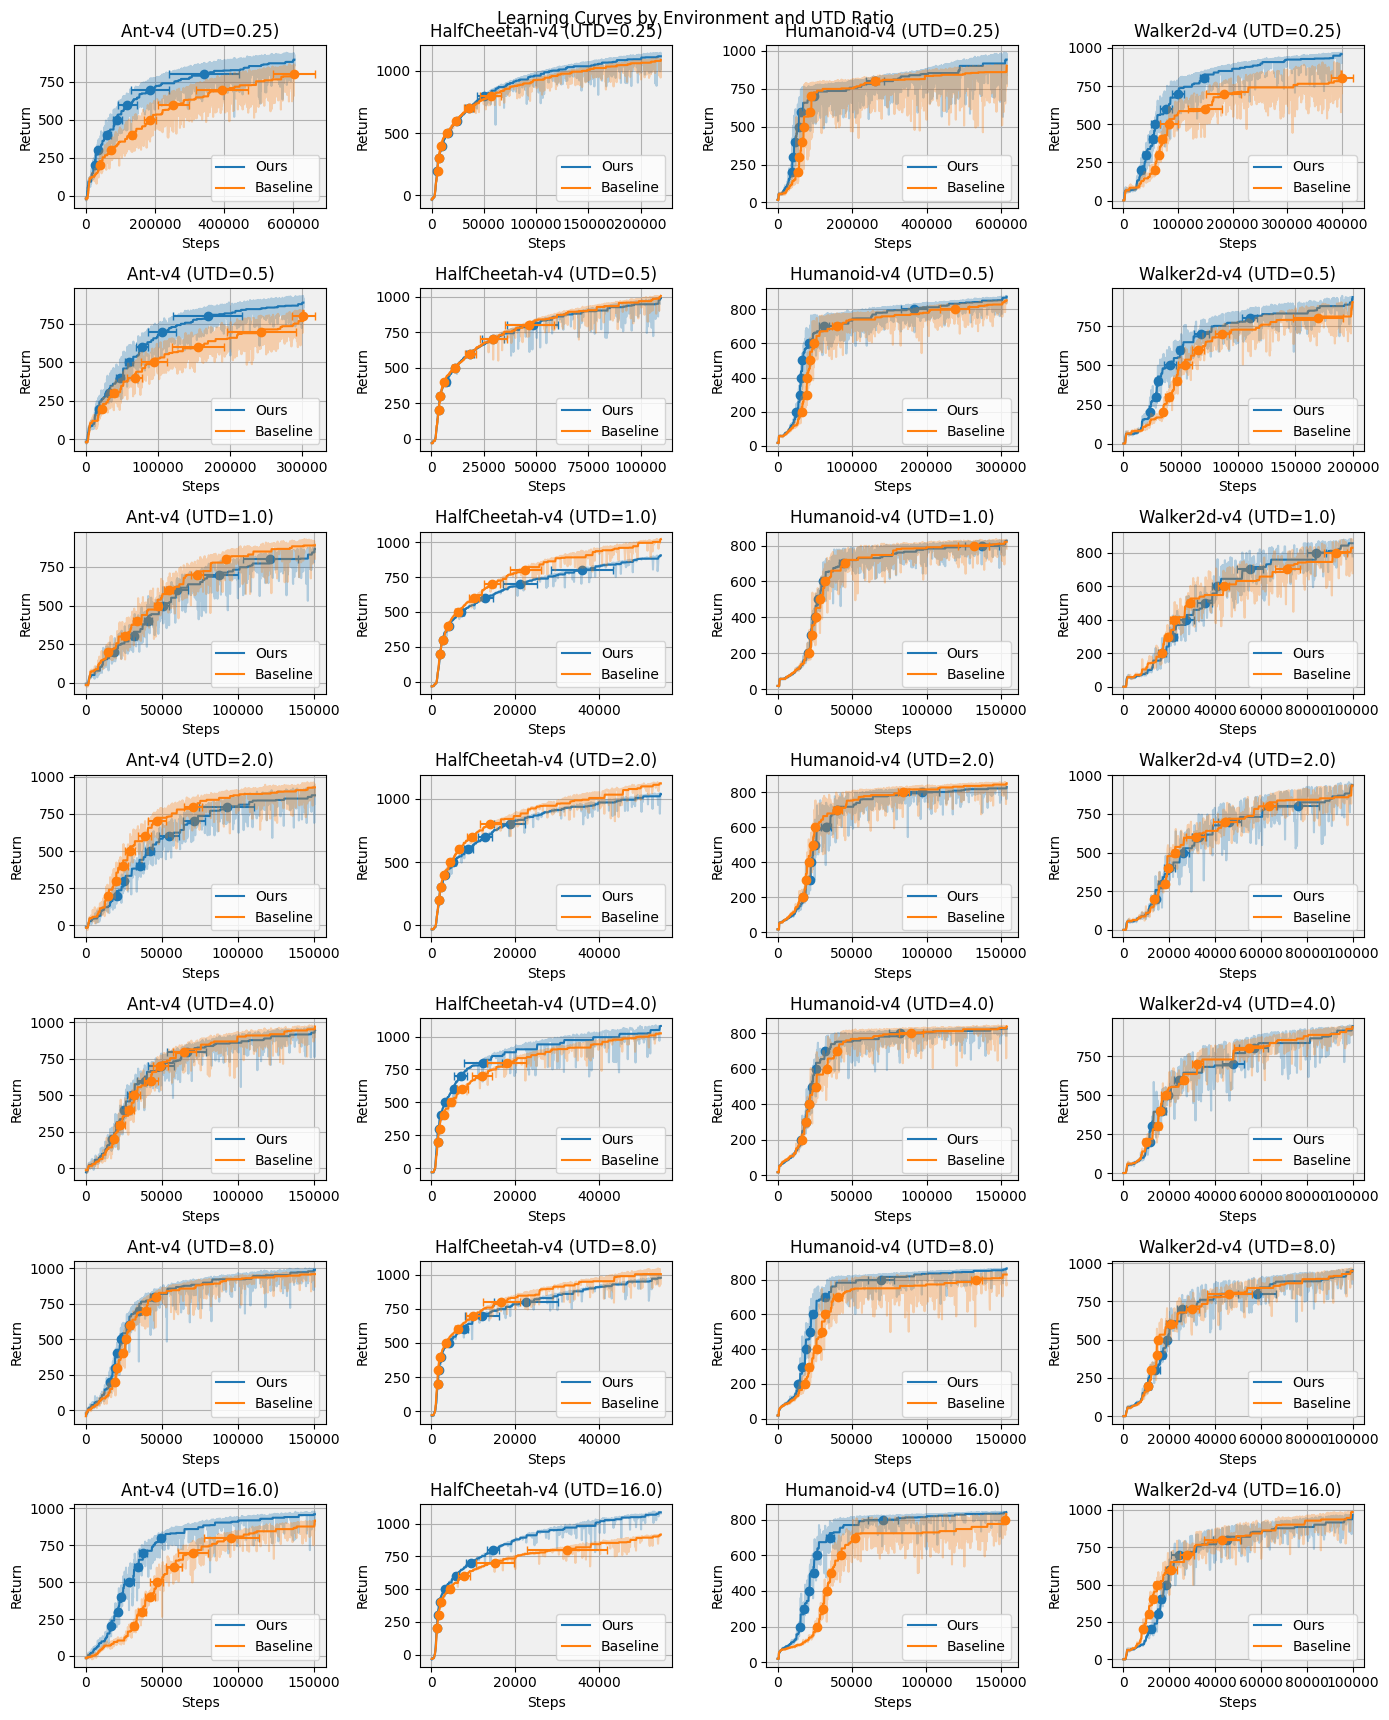

In [ ]:
gym_n_envs = len(gym_envs)
gym_n_utds = len(gym_utds)
dmc_n_envs = len(dmc_envs)
dmc_n_utds = len(dmc_utds)


def plot_curves(ours_df, baseline_df, envs, n_utds, n_envs):
    fig, axs = plt.subplots(n_utds, n_envs, figsize=(3.5 * n_envs, 2.5 * n_utds))
    fig.suptitle('Learning Curves by Environment and UTD Ratio')

    def helper(axs, df, label, color):
        # Group data by environment and UTD ratio
        for i, env in enumerate(envs):
            env_data = df[df['env_name'] == env]
            for j, utd in enumerate(sorted(env_data['utd'].unique())):
                utd_data = env_data[env_data['utd'] == utd]

                ax = axs[j, i]
                ax.set_title(f'{env} (UTD={utd})')

                for _, row in utd_data.iterrows():
                    # ax_label = f"{label}: bs={row['batch_size']}, lr={row['learning_rate']}"
                    ax.plot(row['training_step'], row['mean_return'], color=color, alpha=0.3)
                    ax.plot(row['training_step'], row['return_isotonic'], color=color, alpha=1, label=label)

                    # use the crossings column to plot crossings
                    for k, threshold in enumerate(thresholds):
                        crossing_x = row['crossings'][k]
                        crossing_y = threshold
                        ax.plot(crossing_x, crossing_y, 'o', color=color)

                    # Plot crossing standard deviations as error bars
                    for k, threshold in enumerate(thresholds):
                        crossing_x = row['crossings'][k]
                        crossing_y = threshold
                        crossing_std = row['crossings_std'][k]
                        ax.errorbar(crossing_x, crossing_y, xerr=crossing_std, capsize=3, color=color)

                ax.set_xlabel('Steps')
                ax.set_ylabel('Return')
                ax.grid(True)
                ax.set_facecolor('#f0f0f0')
                ax.legend()

    helper(axs, ours_df, 'Ours', 'tab:blue')
    helper(axs, baseline_df, 'Baseline', 'tab:orange')
    plt.tight_layout()
    plt.show()


plot_curves(gym_ours_df, gym_baseline_df, gym_envs, gym_n_utds, gym_n_envs)

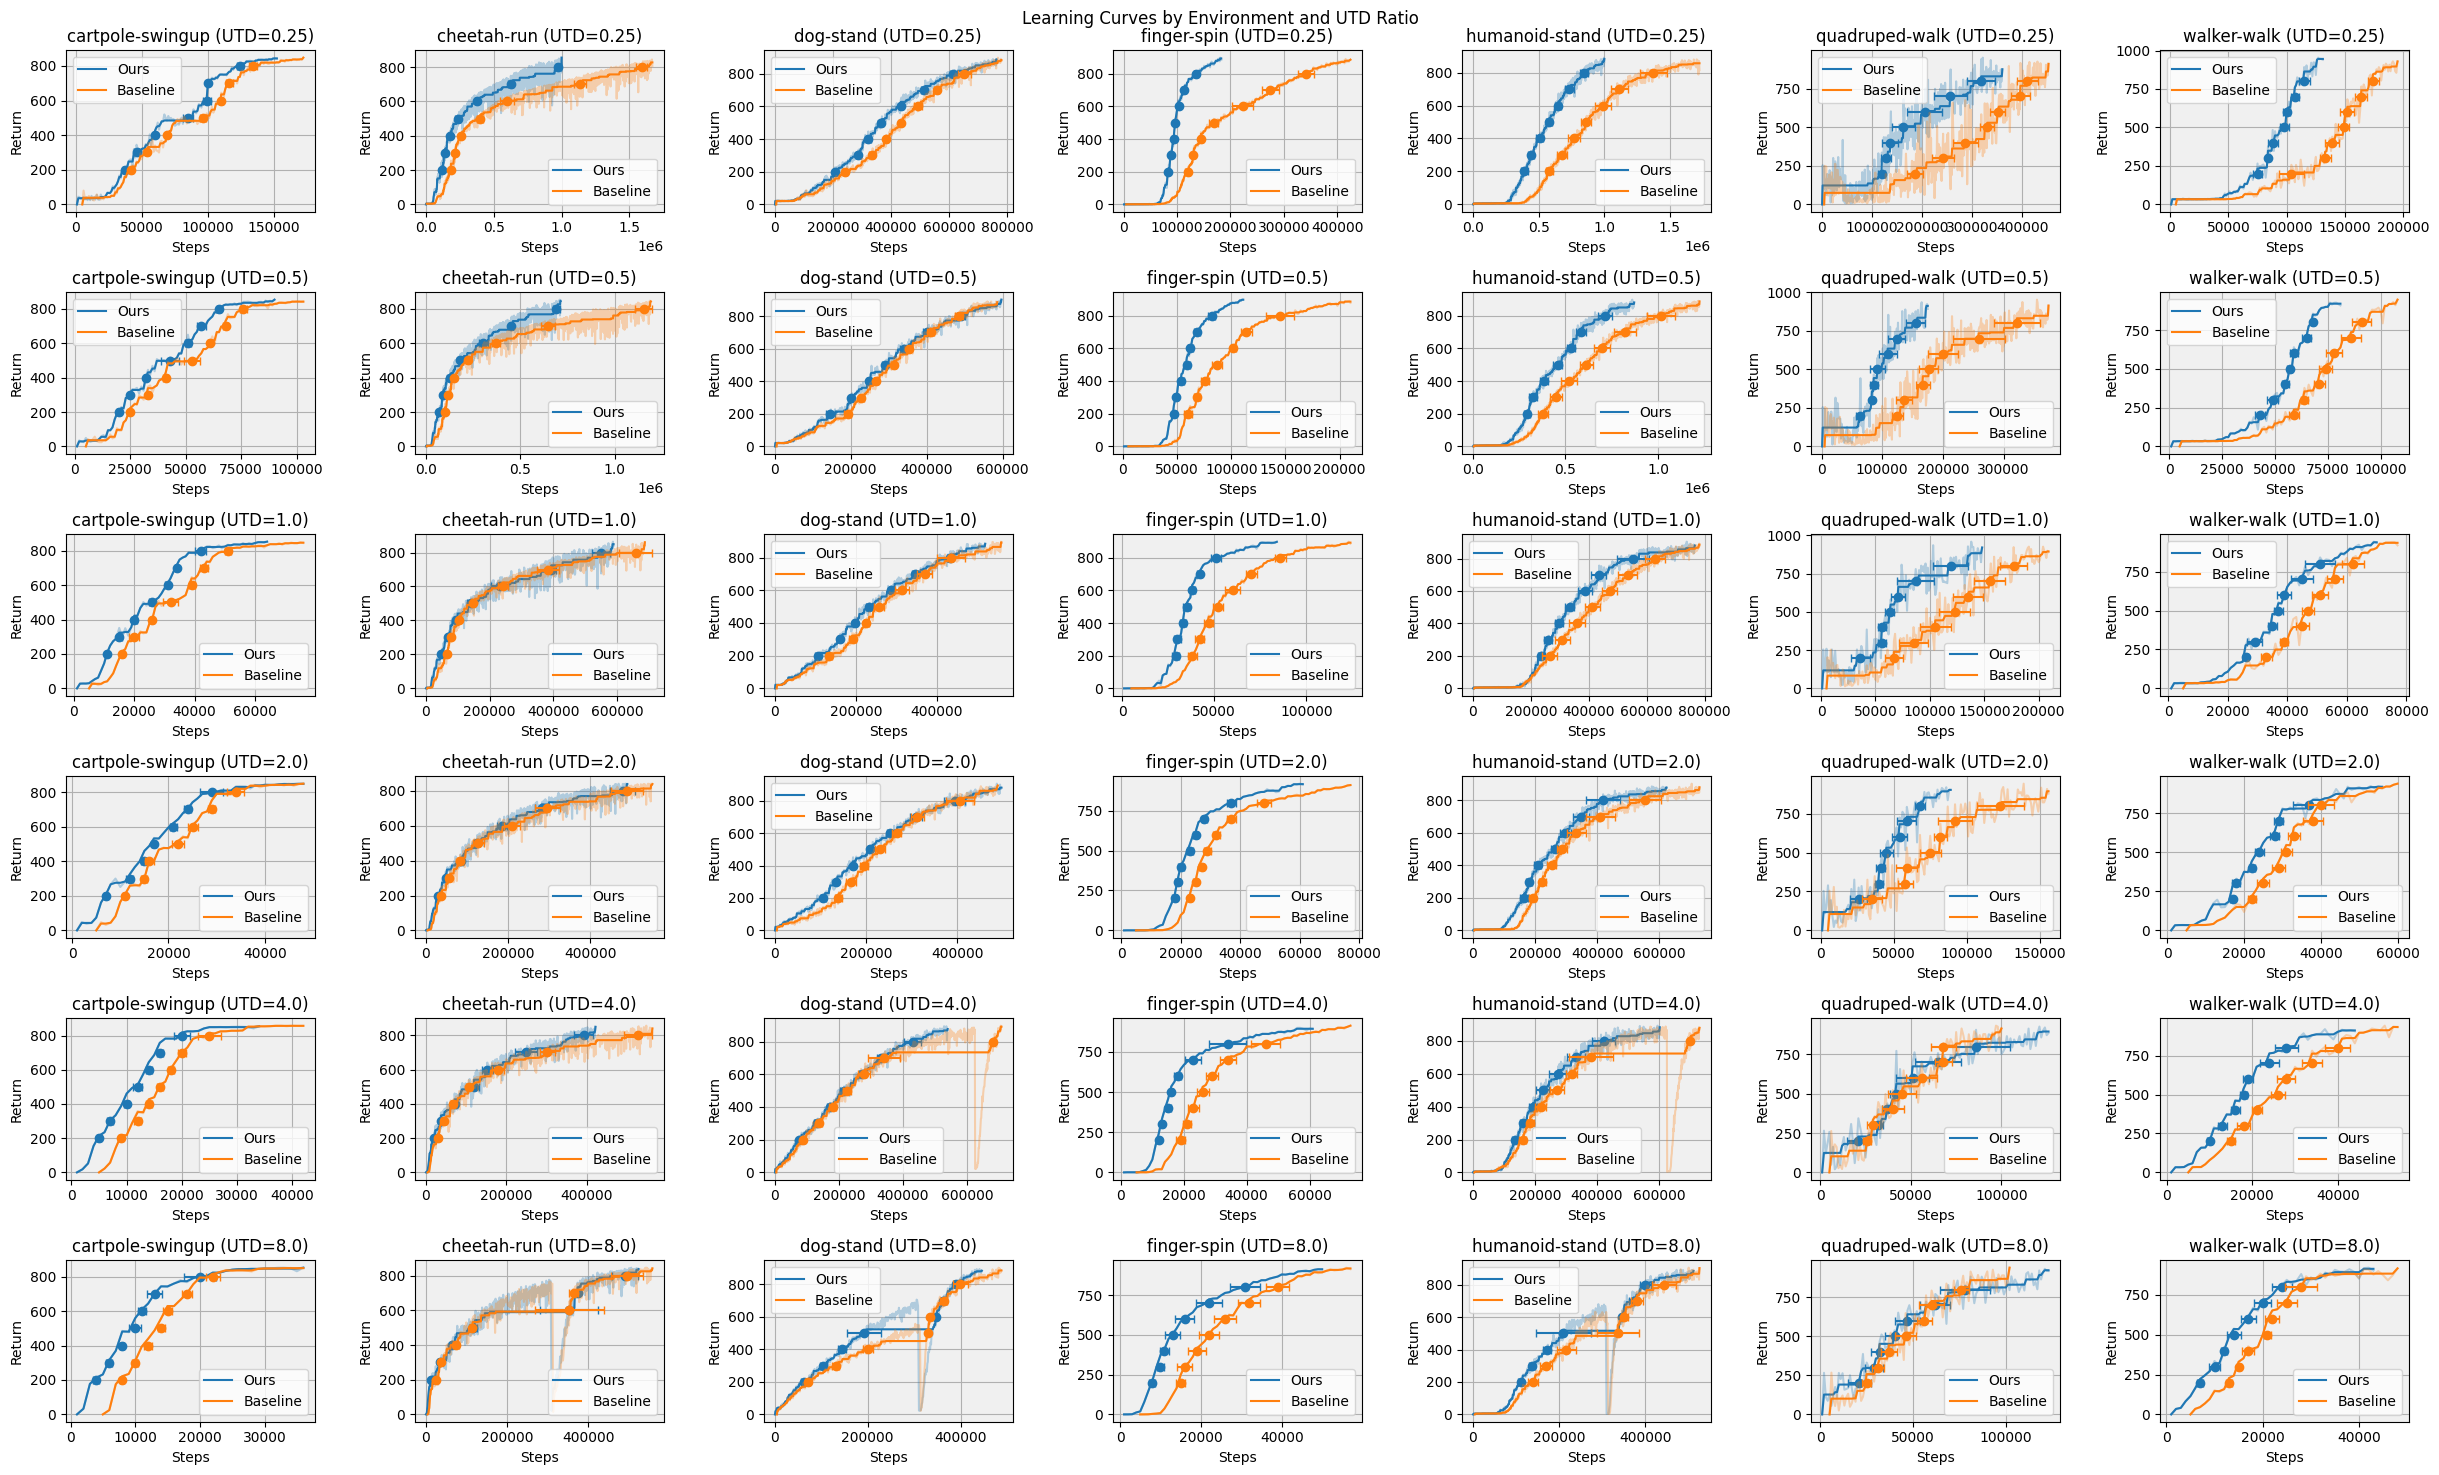

In [ ]:
plot_curves(dmc_ours_df, dmc_baseline_df, dmc_envs, dmc_n_utds, dmc_n_envs)

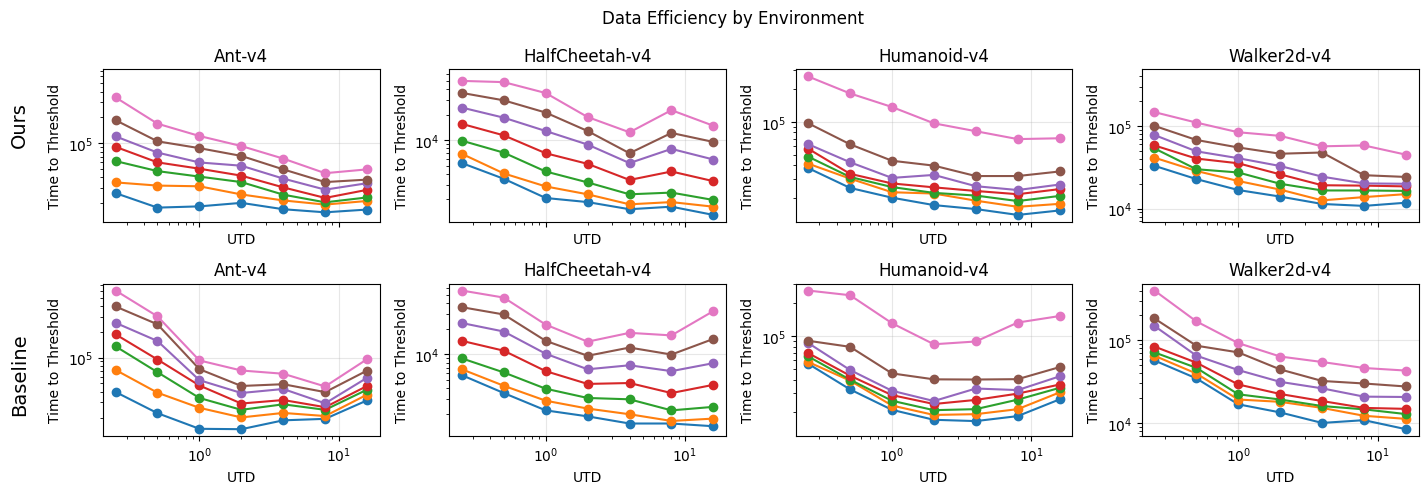

In [ ]:
def plot_data_efficiency(ours_df, baseline_df, envs, n_envs):
    """For a particular threshold, get utds and times"""

    fig, axs = plt.subplots(2, n_envs, figsize=(3.5 * n_envs, 2.5 * 2), sharex='col', sharey='col')
    fig.suptitle('Data Efficiency by Environment')

    def helper(axes, df):
        axes = axes.flatten()
        env_data_dict = {}

        for i, env in enumerate(envs):
            env_df = df[df['env_name'] == env]

            # Get UTD and crossing times for this environment, sorted by UTD
            utds = sorted(env_df['utd'].values)
            times = [env_df[env_df['utd'] == utd]['crossings'].iloc[0][:] for utd in utds]
            env_data_dict[env] = list(zip(utds, times))

            # Plot if we have data
            if len(utds) > 0:
                axes[i].plot(utds, times, 'o-')
                axes[i].set_xlabel('UTD')
                axes[i].set_ylabel('Time to Threshold')
                axes[i].set_title(env)
                axes[i].set_xscale('log')
                axes[i].set_yscale('log')
                axes[i].grid(True, alpha=0.3)

        return env_data_dict

    ours_env_data_dict = helper(axs[0], ours_df)
    baseline_env_data_dict = helper(axs[1], baseline_df)
    fig.text(-0.01, 0.75, 'Ours', va='center', ha='center', fontsize=14, rotation=90)
    fig.text(-0.01, 0.25, 'Baseline', va='center', ha='center', fontsize=14, rotation=90)
    plt.tight_layout()
    plt.show()

    return ours_env_data_dict, baseline_env_data_dict


gym_ours_env_data_dict, gym_baseline_env_data_dict = plot_data_efficiency(
    gym_ours_df, gym_baseline_df, gym_envs, gym_n_envs
)

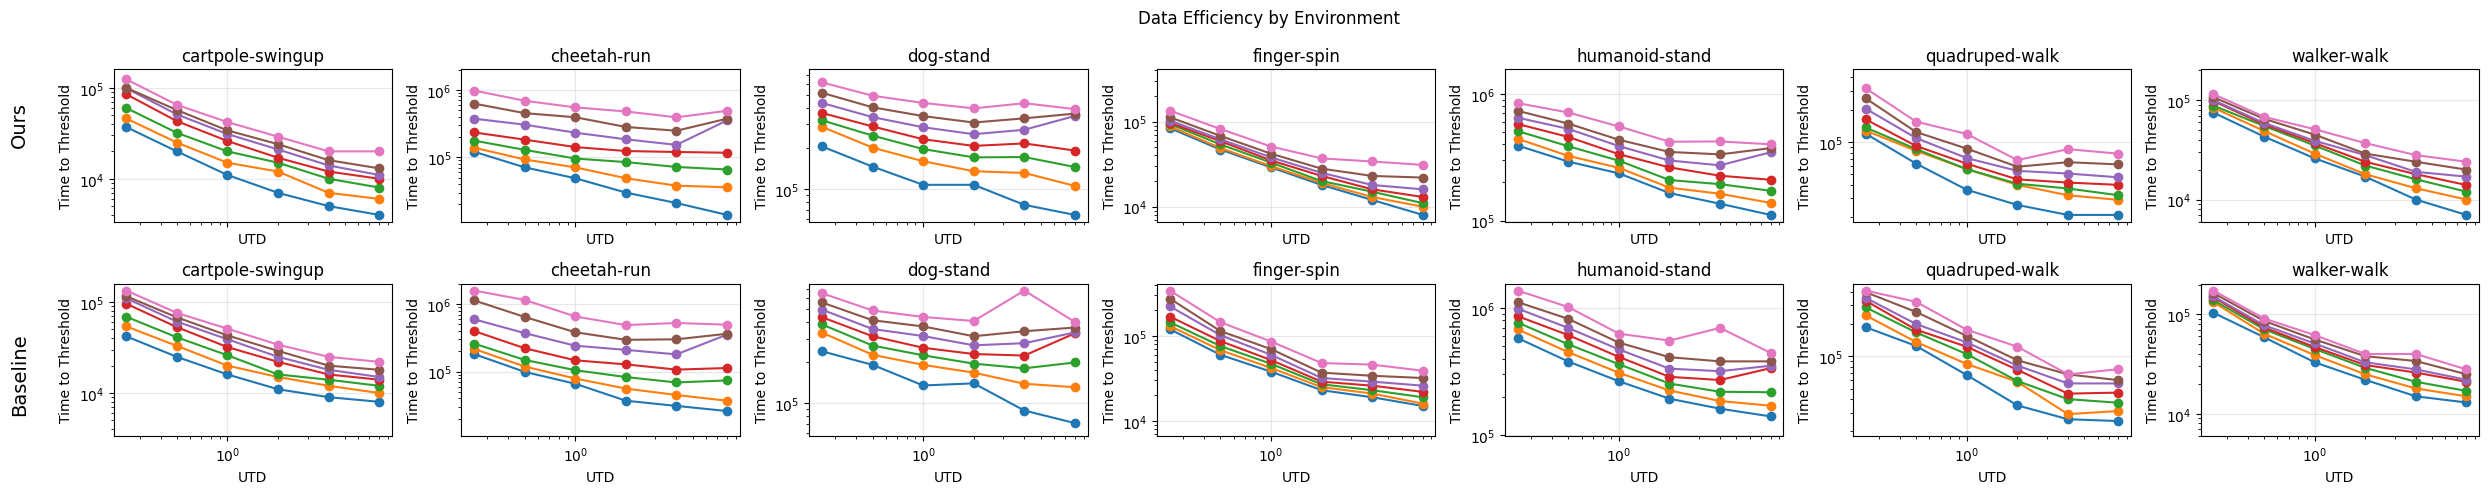

In [ ]:
dmc_ours_env_data_dict, dmc_baseline_env_data_dict = plot_data_efficiency(
    dmc_ours_df, dmc_baseline_df, dmc_envs, dmc_n_envs
)

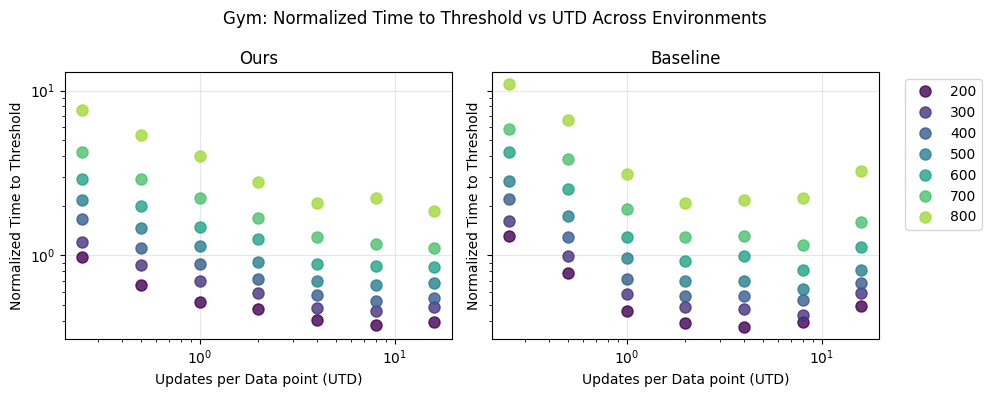

In [ ]:
def combine_envs_plot(domain, ours_env_data_dict, baseline_env_data_dict, envs):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

    def helper(ax, envs, env_data_dict, label, show_legend: bool):
        # Calculate median times and scaling factors for each environment
        median_times = np.array(
            [np.median(list(zip(*env_data_dict[env]))[1]) for env in envs if len(env_data_dict[env]) > 0]
        )
        median_median = np.median(median_times)
        scaling = 1 / median_times

        # Store the normalized data for each environment
        normalized_times_all = []
        for i, env in enumerate(envs):
            if len(env_data_dict[env]) > 0:
                utds, times = zip(*env_data_dict[env])
                normalized_times = np.array(times) * scaling[i]
                normalized_times_all.append(normalized_times)

        # Calculate and plot the average across all environments
        normalized_times_all = np.array(normalized_times_all)
        mean_normalized_times = np.mean(normalized_times_all, axis=0)
        n_thresholds = mean_normalized_times.shape[-1]

        for i in range(n_thresholds):
            ax.plot(
                utds,
                mean_normalized_times[:, i],
                'o',
                color=plt.cm.viridis(i / n_thresholds),
                label=f'{thresholds[i]}',
                markersize=8,
                alpha=0.8,
            )

        ax.set_title(label)
        ax.set_xlabel('Updates per Data point (UTD)')
        ax.set_ylabel('Normalized Time to Threshold')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        if show_legend:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        return n_thresholds, normalized_times_all, mean_normalized_times, median_median

    (n_thresholds, ours_normalized_times_all, ours_mean_normalized_times, ours_median_median) = helper(
        axs[0], envs, ours_env_data_dict, 'Ours', show_legend=False
    )
    (_, baseline_normalized_times_all, baseline_mean_normalized_times, baseline_median_median) = helper(
        axs[1], envs, baseline_env_data_dict, 'Baseline', show_legend=True
    )

    plt.suptitle(f'{domain}: Normalized Time to Threshold vs UTD Across Environments')
    plt.tight_layout()
    plt.show()

    return (
        n_thresholds,
        ours_normalized_times_all,
        ours_mean_normalized_times,
        ours_median_median,
        baseline_normalized_times_all,
        baseline_mean_normalized_times,
        baseline_median_median,
    )


(
    gym_n_thresholds,
    gym_ours_normalized_times_all,
    gym_ours_mean_normalized_times,
    gym_ours_median_median,
    gym_baseline_normalized_times_all,
    gym_baseline_mean_normalized_times,
    gym_baseline_median_median,
) = combine_envs_plot('Gym', gym_ours_env_data_dict, gym_baseline_env_data_dict, gym_envs)

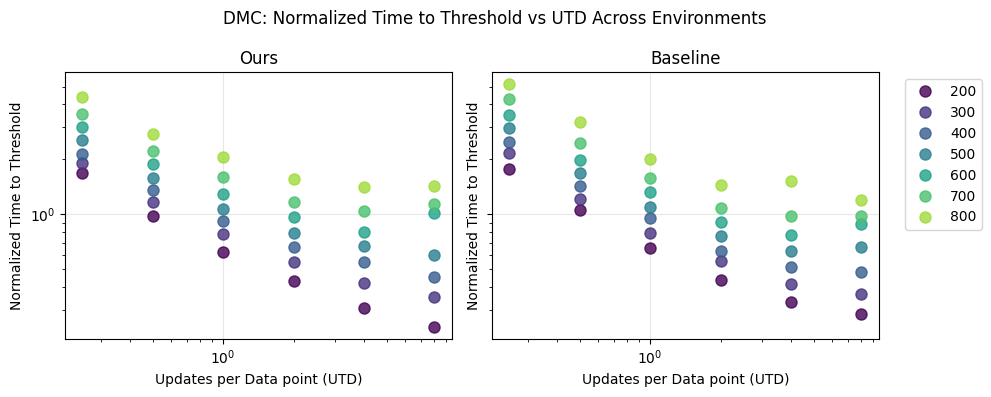

In [ ]:
(
    dmc_n_thresholds,
    dmc_ours_normalized_times_all,
    dmc_ours_mean_normalized_times,
    dmc_ours_median_median,
    dmc_baseline_normalized_times_all,
    dmc_baseline_mean_normalized_times,
    dmc_baseline_median_median,
) = combine_envs_plot('DMC', dmc_ours_env_data_dict, dmc_baseline_env_data_dict, dmc_envs)

# Asymptotic data efficiency fit

In [ ]:
def fit(xs, y, optim_f, init_grid, top_k=500, tol=None, disp=False, maxiter=None):
    _, _, brute_xs, brute_ys = scipy.optimize.brute(
        optim_f, init_grid, args=(xs, y), full_output=True, finish=None, Ns=1, workers=-1
    )

    brute_xs = brute_xs.reshape(brute_xs.shape[0], -1)
    brute_ys = brute_ys.reshape(-1)

    top_idxs = np.argsort(brute_ys)[:top_k]
    top_xs = brute_xs[:, top_idxs]
    preds = []
    for i in tqdm(range(top_xs.shape[1])):
        options = {'disp': disp}
        if maxiter:
            options['maxiter'] = maxiter
        pred = scipy.optimize.minimize(
            optim_f, top_xs[:, i], args=(xs, y), method='L-BFGS-B', tol=tol, options=options
        ).x
        loss = optim_f(pred, xs, y)
        # print(pred, loss)
        preds.append((pred, loss))
    return sorted(preds, key=lambda x: x[1])[0][0]


def power_law_with_const_min(args, *params):
    x, y = params
    a, b, c = args
    with np.errstate(invalid='ignore', divide='ignore'):
        return ((np.log(power_law_with_const(x, a, b, c) / y)) ** 2).mean()


def power_law_with_const(x, a, b, c):
    return c * (1 + (x / b) ** (-a))

In [ ]:
def make_pareto_fits(utds, n_thresholds, mean_normalized_times):
    fits = []
    for i in range(n_thresholds):
        params = fit(
            utds[:],
            mean_normalized_times[:, i],
            power_law_with_const_min,
            [slice(-2, 2, 0.8), slice(0, 1, 0.2), slice(-2, 2, 0.8)],
            maxiter=100,
        )
        fits.append(params)

    return fits


gym_ours_fits = make_pareto_fits(gym_utds, gym_n_thresholds, gym_ours_mean_normalized_times)
gym_baseline_fits = make_pareto_fits(gym_utds, gym_n_thresholds, gym_baseline_mean_normalized_times)
dmc_ours_fits = make_pareto_fits(dmc_utds, dmc_n_thresholds, dmc_ours_mean_normalized_times)
dmc_baseline_fits = make_pareto_fits(dmc_utds, dmc_n_thresholds, dmc_baseline_mean_normalized_times)

  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2576433/4198437483.py:28: RuntimeWarning: overflow encountered in power
  return c * (1 + (x/b)**(-a))
 27%|██▋       | 34/125 [00:00<00:00, 162.51it/s]/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
 14%|█▎        | 17/125 [00:00<00:00, 156.37it/s]/tmp/ipykernel_2576433/4198437483.py:28: RuntimeWarning: overflow encountered in multiply
  return c * (1 + (x/b)**(-a))
100%|██████████| 125/125 [00:00<00:00, 225.25it/s]


TODO: figure out compute

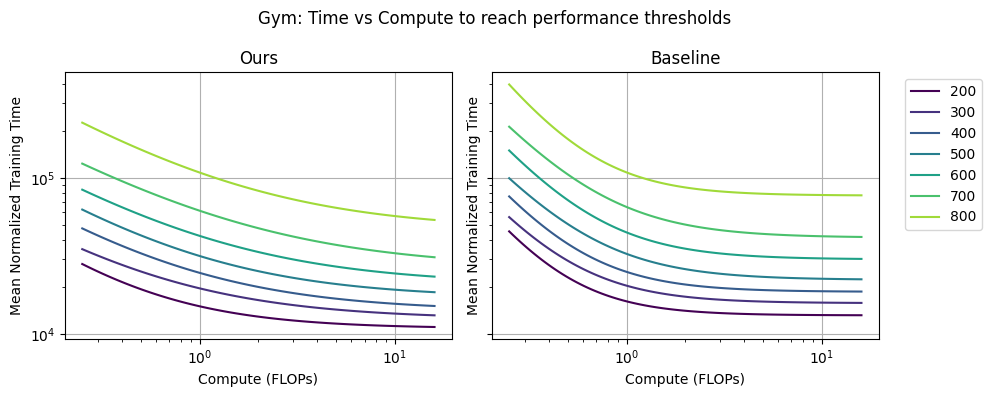

In [ ]:
def plot_pareto_fits(
    domain,
    ours_fits,
    ours_median_median,
    baseline_fits,
    baseline_median_median,
    utds,
    n_thresholds,
):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

    def helper(ax, fits, median_median, label: str, show_legend: bool):
        for i in range(n_thresholds):
            x_smooth = np.logspace(np.log10(min(utds)), np.log10(max(utds)), 100)
            a, b, c = fits[i]
            data = power_law_with_const(x_smooth, a, b, c) * median_median
            utd = x_smooth

            grad_steps = utd * data
            batch_sizes = 300 * (utd) ** (-0.3)
            compute = grad_steps * batch_sizes * 10 * 1.5e5

            # Plot the fit
            ax.plot(utd, data, '-', color=plt.cm.viridis(i / n_thresholds), label=thresholds[i])

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True)
        ax.set_xlabel('Compute (FLOPs)')
        ax.set_ylabel('Mean Normalized Training Time')
        ax.set_title(label)
        if show_legend:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        os.makedirs('outputs/fits', exist_ok=True)
        np.save(f'outputs/fits/{label.lower()}_fits.npy', fits)

        return x_smooth

    x_smooth = helper(axs[0], ours_fits, ours_median_median, 'Ours', show_legend=False)
    _ = helper(axs[1], baseline_fits, baseline_median_median, 'Baseline', show_legend=True)
    plt.suptitle(f'{domain}: Time vs Compute to reach performance thresholds')
    plt.tight_layout()
    plt.show()

    return x_smooth


gym_x_smooth = plot_pareto_fits(
    'Gym',
    gym_ours_fits,
    gym_ours_median_median,
    gym_baseline_fits,
    gym_baseline_median_median,
    gym_utds,
    gym_n_thresholds,
)

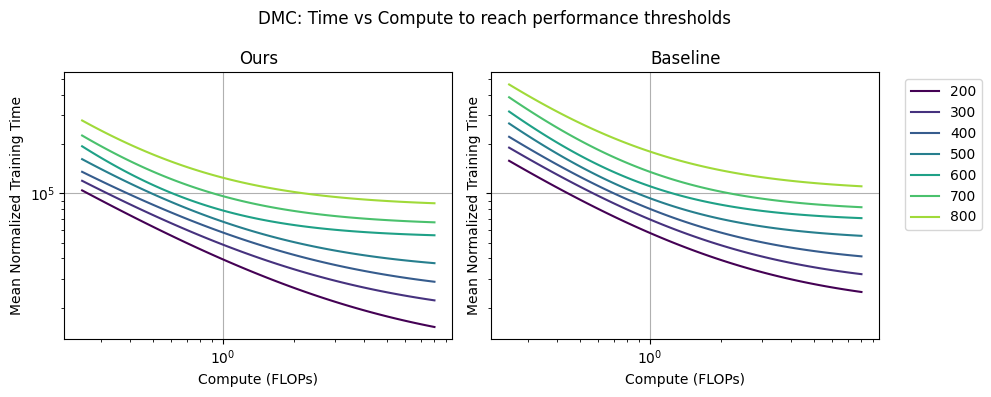

In [ ]:
dmc_x_smooth = plot_pareto_fits(
    'DMC',
    dmc_ours_fits,
    dmc_ours_median_median,
    dmc_baseline_fits,
    dmc_baseline_median_median,
    dmc_utds,
    dmc_n_thresholds,
)

# Final plots

In [ ]:
from rliable import plot_utils

COLORS = ['#BBCC33', '#77AADD', '#44BB99', '#EEDD88', '#EE8866', '#FFAABB', '#99DDFF', '#AAAA00', '#DDDDDD']
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False  # Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath'  # Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif'  # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue']  # Choose a nice font here
sns.set_style('whitegrid')

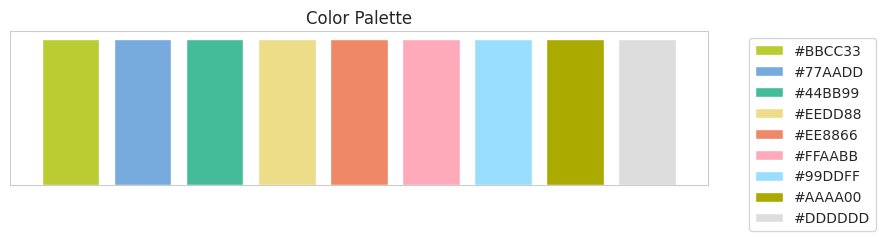

In [ ]:
plt.figure(figsize=(9, 2))
for i, color in enumerate(COLORS):
    plt.bar(i, 1, color=color, label=color)
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Color Palette')
plt.show()

Gym
Fits using threshold 800
Ours: y = 1.61 * (1 + (x/1.44)**(-0.77))
Constant fit: y = 2.33 * (1 + (x/0.58)**(-1.67))


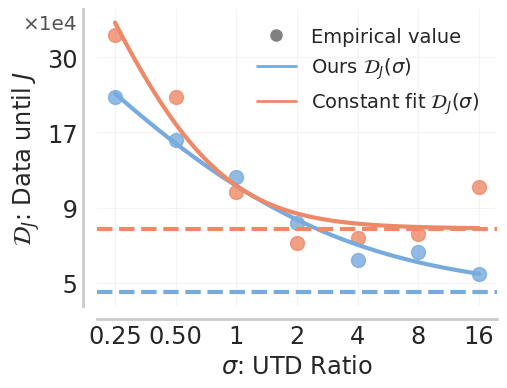

In [ ]:
pareto_fit_idx = -1


def plot_utd_data(
    x_smooth,
    ours_median_median,
    ours_fits,
    ours_normalized_times_all,
    baseline_median_median,
    baseline_fits,
    baseline_normalized_times_all,
    utds,
    ylim,
    yscale: str,
):
    fig, axs = plt.subplots(1, 1, figsize=(10, 8))
    fig.set_size_inches(496.0 / 192 * 2, 369.6 / 192 * 2)

    print(f'Fits using threshold {thresholds[pareto_fit_idx]}')
    y_min, y_max = ylim

    def helper(idx, x_smooth, median_median, fits, normalized_times_all, label, color):
        a, b, c = fits[idx]
        print(f'{label}: y = {c:.2f} * (1 + (x/{b:.2f})**(-{a:.2f}))')
        utd_line = x_smooth
        data_line = power_law_with_const(x_smooth, a, b, c) * median_median
        plt.scatter(
            utds,
            np.mean(normalized_times_all[..., idx], axis=0) * median_median,
            marker='o',
            color=color,
            label=f'{label} empirical value',
            alpha=0.8,
            s=100,
        )
        plt.plot(utd_line, data_line, color, linewidth=3, label=label + ' $\mathcal{D}_J(\sigma)$')

        # Asymptote
        plt.axhline(
            y=c * median_median,
            color=color,
            linewidth=3,
            linestyle='--',
            label=label + ' $\mathcal{D}_J^{\mathrm{min}}$',
        )

        plt.xscale('log')
        plt.yscale('log')
        x = np.logspace(np.log10(min(utds)), np.log10(max(utds)), num=len(utds))
        x_ticks_labels = [round(x) if x >= 0.99 else f'{x:.2f}' for x in x]
        # x_ticks_labels = [f"{x:.2f}" for x in x]
        axs.set_xticks(x, x_ticks_labels)
        yticks = np.logspace(np.log10(y_min), np.log10(y_max), num=4, dtype=int)
        ylabels = ['%2.f' % (y / float(yscale)) for y in yticks]
        axs.yaxis.set_major_locator(plt.FixedLocator(yticks))
        axs.yaxis.set_minor_locator(plt.NullLocator())
        axs.set_yticks(yticks, ylabels, size=14.5)

        plot_utils._annotate_and_decorate_axis(
            axs,
            xlabel='$\sigma$: UTD Ratio',
            ylabel='$\mathcal{D}_J$: Data until $J$',
            labelsize='xx-large',
            ticklabelsize='xx-large',
            grid_alpha=0.2,
            legend=False,
        )

    helper(
        pareto_fit_idx,
        x_smooth,
        ours_median_median,
        ours_fits,
        ours_normalized_times_all,
        label='Ours',
        color=COLORS[1],
    )

    helper(
        pareto_fit_idx,
        x_smooth,
        baseline_median_median,
        baseline_fits,
        baseline_normalized_times_all,
        label='Constant fit',
        color=COLORS[4],
    )

    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Empirical value'),
        Line2D(
            [0], [0], linestyle='-', linewidth=2, markersize=10, color=COLORS[1], label=r'Ours $\mathcal{D}_J(\sigma)$'
        ),
        Line2D(
            [0],
            [0],
            linestyle='-',
            linewidth=2,
            markersize=10,
            color=COLORS[4],
            label=r'Constant fit $\mathcal{D}_J(\sigma)$',
        ),
    ]
    plt.legend(handles=legend_handles, prop={'size': 14}, frameon=False)
    plt.text(
        -0.05,
        0.92,
        f'×{yscale}',
        transform=axs.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize='x-large',
        alpha=0.8,
    )
    plt.show()


print('Gym')
plot_utd_data(
    gym_x_smooth,
    gym_ours_median_median,
    gym_ours_fits,
    gym_ours_normalized_times_all,
    gym_baseline_median_median,
    gym_baseline_fits,
    gym_baseline_normalized_times_all,
    gym_utds,
    (50000, 300000),
    '1e4',
)

DMC
Fits using threshold 800
Ours: y = 1.32 * (1 + (x/0.54)**(-1.12))
Constant fit: y = 1.16 * (1 + (x/0.77)**(-1.11))


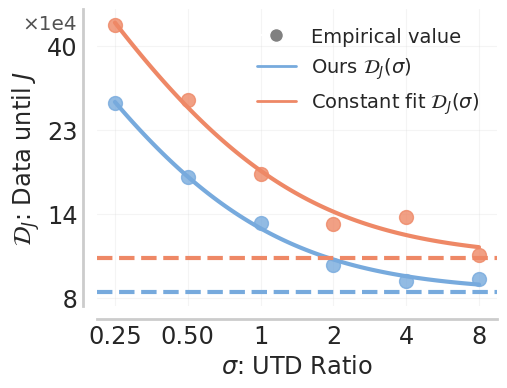

In [ ]:
print('DMC')
plot_utd_data(
    dmc_x_smooth,
    dmc_ours_median_median,
    dmc_ours_fits,
    dmc_ours_normalized_times_all,
    dmc_baseline_median_median,
    dmc_baseline_fits,
    dmc_baseline_normalized_times_all,
    dmc_utds,
    (80000, 400000),
    '1e4',
)

In [ ]:
def load_batch_size_fit(sweep_path):
    params = np.load(f'outputs/grid_proposed_fits/{sweep_path}_bs_fit.npy')
    shared_slope = params[0, 0]
    mean_intercept = np.mean(10 ** params[:, 1])
    return shared_slope, mean_intercept

Threshold = 800
Rough batch size: 391.35 * UTD**-0.35
y = 1.61 * (1 + (x/1.44)**(-0.77)
y = 2.33 * (1 + (x/0.58)**(-1.67)


/tmp/ipykernel_2576433/1677082122.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(prop={'size': 14}, ncol=1, frameon=False)
/tmp/ipykernel_2576433/1677082122.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(prop={'size': 14}, ncol=1, frameon=False)


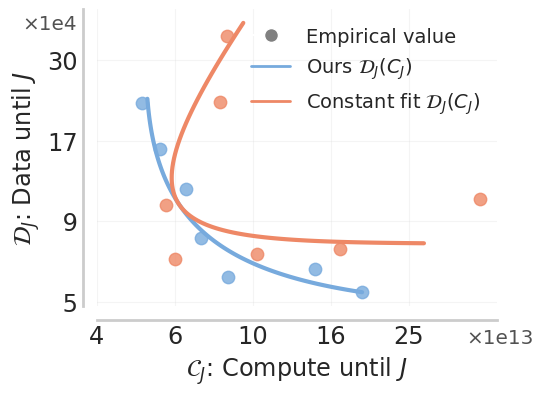

In [ ]:
def plot_compute_data(
    utds,
    x_smooth,
    sweep_path,
    model_size,
    ours_fits,
    ours_median_median,
    ours_normalized_times_all,
    baseline_fits,
    baseline_median_median,
    baseline_normalized_times_all,
    xlim,
    ylim,
    xscale: str,
    yscale: str,
):
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(496.0 / 192 * 2, 369.6 / 192 * 2)
    bs_slope, bs_mean_intercept = load_batch_size_fit(sweep_path)

    print(f'Threshold = {thresholds[pareto_fit_idx]}')
    print(f'Rough batch size: {bs_mean_intercept:.2f} * UTD**{bs_slope:.2f}')

    x_min, x_max = xlim
    y_min, y_max = ylim

    def helper(idx, utds, x_smooth, fits, median_median, normalized_times_all, label, color):
        a, b, c = fits[idx]
        print(f'y = {c:.2f} * (1 + (x/{b:.2f})**(-{a:.2f})')
        data = power_law_with_const(x_smooth, a, b, c) * median_median
        utd_line = x_smooth
        data_line = power_law_with_const(x_smooth, a, b, c) * median_median

        utds = np.array(utds)
        data = np.mean(normalized_times_all[..., idx], axis=0) * median_median

        grad_steps = utds * data
        batch_sizes = bs_mean_intercept * utds**bs_slope
        compute = grad_steps * batch_sizes * 10 * model_size

        grad_steps_line = utd_line * data_line
        batch_sizes_line = bs_mean_intercept * utd_line**bs_slope
        compute_line = grad_steps_line * batch_sizes_line * 10 * model_size

        plt.scatter(compute[:], data[:], marker='o', color=color, alpha=0.8, s=80)
        plt.plot(compute_line, data_line, color, linewidth=3)

        plt.xscale('log')
        plt.yscale('log')
        axs.legend(prop={'size': 14}, ncol=1, frameon=False)

        x = np.logspace(np.log10(x_min), np.log10(x_max), num=5)
        x_ticks_labels = [f'{x / float(xscale):.0f}' for x in x]
        axs.xaxis.set_major_locator(plt.FixedLocator(x))
        axs.xaxis.set_minor_locator(plt.NullLocator())
        axs.set_xticks(x, x_ticks_labels)

        yticks = np.logspace(np.log10(y_min), np.log10(y_max), num=4, dtype=int)
        ylabels = ['%2.f' % (y / float(yscale)) for y in yticks]
        axs.yaxis.set_major_locator(plt.FixedLocator(yticks))
        axs.yaxis.set_minor_locator(plt.NullLocator())
        axs.set_yticks(yticks, ylabels, size=14.5)

        plot_utils._annotate_and_decorate_axis(
            axs,
            xlabel='$\mathcal{C}_J$: Compute until $J$',
            ylabel='$\mathcal{D}_J$: Data until $J$',
            labelsize='xx-large',
            ticklabelsize='xx-large',
            grid_alpha=0.2,
            legend=False,
        )

    helper(pareto_fit_idx, utds, x_smooth, ours_fits, ours_median_median, ours_normalized_times_all, 'Ours', COLORS[1])
    helper(
        pareto_fit_idx,
        utds,
        x_smooth,
        baseline_fits,
        baseline_median_median,
        baseline_normalized_times_all,
        'Baseline',
        COLORS[4],
    )

    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Empirical value'),
        Line2D(
            [0], [0], linestyle='-', linewidth=2, markersize=10, color=COLORS[1], label=r'Ours $\mathcal{D}_J(C_J)$'
        ),
        Line2D(
            [0],
            [0],
            linestyle='-',
            linewidth=2,
            markersize=10,
            color=COLORS[4],
            label=r'Constant fit $\mathcal{D}_J(C_J)$',
        ),
    ]
    plt.legend(handles=legend_handles, prop={'size': 14}, frameon=False)
    plt.text(
        1.09,
        -0.14,
        f'×{xscale}',
        transform=axs.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize='x-large',
        alpha=0.8,
    )
    plt.text(
        -0.05,
        0.92,
        f'×{yscale}',
        transform=axs.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize='x-large',
        alpha=0.8,
    )
    plt.show()


plot_compute_data(
    gym_utds,
    gym_x_smooth,
    gym_sweep_path,
    gym_model_size,
    gym_ours_fits,
    gym_ours_median_median,
    gym_ours_normalized_times_all,
    gym_baseline_fits,
    gym_baseline_median_median,
    gym_baseline_normalized_times_all,
    (4e13, 25e13),
    (50000, 300000),
    '1e13',
    '1e4',
)

Threshold = 800
Rough batch size: 391.35 * UTD**-0.35
y = 1.32 * (1 + (x/0.54)**(-1.12)
y = 1.16 * (1 + (x/0.77)**(-1.11)


/tmp/ipykernel_2576433/1677082122.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(prop={'size': 14}, ncol=1, frameon=False)
/tmp/ipykernel_2576433/1677082122.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(prop={'size': 14}, ncol=1, frameon=False)


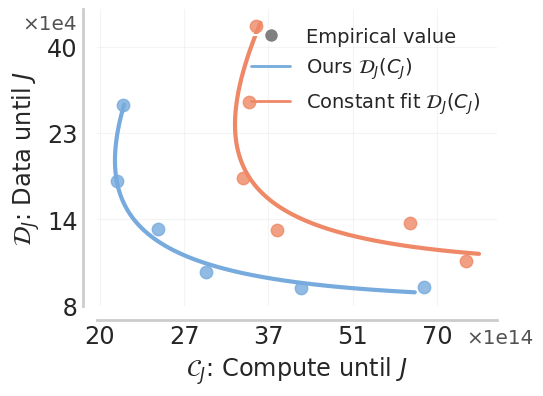

In [ ]:
plot_compute_data(
    dmc_utds,
    dmc_x_smooth,
    dmc_sweep_path,
    dmc_model_size,
    dmc_ours_fits,
    dmc_ours_median_median,
    dmc_ours_normalized_times_all,
    dmc_baseline_fits,
    dmc_baseline_median_median,
    dmc_baseline_normalized_times_all,
    (20e14, 70e14),
    (80000, 400000),
    '1e14',
    '1e4',
)

TODO: insert documentation on how to select $\delta$

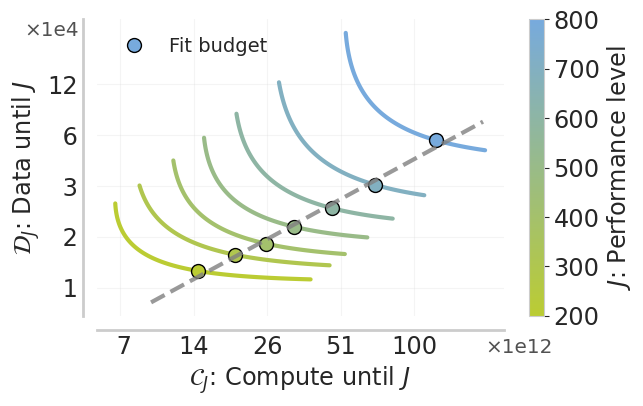

In [ ]:
def plot_compute_data_isoperformance(
    fits, median_median, n_thresholds, utds, sweep_path, model_size, delta, xlim, ylim, xscale: str, yscale: str
):
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(496.0 / 192 * 2 * 1.27, 369.6 / 192 * 2)

    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
    n_colors = n_thresholds
    colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

    min_points_compute = []
    min_points_data = []
    min_points_utd = []

    bs_slope, bs_mean_intercept = load_batch_size_fit(sweep_path)
    x_min, x_max = xlim
    y_min, y_max = ylim

    for i in range(n_thresholds):
        # Generate smooth curves and plot fits for each threshold
        x_smooth = np.logspace(np.log10(min(utds)), np.log10(max(utds)), 100)
        a, b, c = fits[i]
        data = power_law_with_const(x_smooth, a, b, c) * median_median
        utd = x_smooth

        # Convert UTD ratio to compute using the formula from dmc_data5_fits.ipynb
        grad_steps = utd * data
        batch_sizes = bs_mean_intercept * utd**bs_slope
        compute = grad_steps * batch_sizes * 10 * model_size

        # Plot the fit
        plt.plot(compute, data, '-', color=colors[i], linewidth=3)

        # Find and mark minimum point
        min_idx = np.argmin(compute + delta * data)
        plt.plot(
            compute[min_idx],
            data[min_idx],
            'o',
            color=colors[i],
            markersize=10,
            label='Fit budget' if i == len(thresholds) - 1 else None,
            markeredgecolor='black',
        )

        # Store min points for fitting line
        min_points_compute.append(compute[min_idx])
        min_points_data.append(data[min_idx])
        min_points_utd.append(utd[min_idx])

    # UTD extrapolation line
    min_points_utd = np.array(min_points_utd)
    min_points_data = np.array(min_points_data)
    min_points_compute = np.array(min_points_compute)
    # Fit line in log space
    coeffs = np.polyfit(np.log10(min_points_compute), np.log10(min_points_data), 1)
    # Generate points for the ours line
    x_range = np.log10(min(min_points_compute)), np.log10(max(min_points_compute))
    x_line = np.logspace(
        x_range[0] - 0.2 * (x_range[1] - x_range[0]),
        x_range[1] + 0.2 * (x_range[1] - x_range[0]),
        100,
    )
    y_line = 10 ** (coeffs[0] * np.log10(x_line) + coeffs[1])
    plt.plot(x_line, y_line, '--', color='gray', linewidth=3, alpha=0.8)

    plt.xscale('log')
    plt.yscale('log')
    axs.legend(prop={'size': 14}, ncol=1, frameon=False)

    x = np.logspace(np.log10(x_min), np.log10(x_max), num=5, dtype=int)
    xlabels = ['%2.f' % (y / float(xscale)) for y in x]
    axs.xaxis.set_major_locator(plt.FixedLocator(x))
    axs.xaxis.set_minor_locator(plt.NullLocator())
    axs.set_xticks(x, xlabels, size=14.5)

    yticks = np.logspace(np.log10(y_min), np.log10(y_max), num=5, dtype=int)
    ylabels = ['%2.f' % (y / float(yscale)) for y in yticks]
    axs.yaxis.set_major_locator(plt.FixedLocator(yticks))
    axs.yaxis.set_minor_locator(plt.NullLocator())
    axs.set_yticks(yticks, ylabels, size=14.5)

    plot_utils._annotate_and_decorate_axis(
        axs,
        xlabel='$\mathcal{C}_J$: Compute until $J$',
        ylabel='$\mathcal{D}_J$: Data until $J$',
        labelsize='xx-large',
        ticklabelsize='xx-large',
        grid_alpha=0.2,
        legend=False,
    )

    plt.text(
        1.12,
        -0.14,
        f'×{xscale}',
        transform=axs.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize='x-large',
        alpha=0.8,
    )
    plt.text(
        -0.045,
        0.93,
        f'×{yscale}',
        transform=axs.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize='x-large',
        alpha=0.8,
    )

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(thresholds), vmax=max(thresholds)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('$J$: Performance level', size='xx-large')
    cbar.ax.tick_params(labelsize='xx-large')

    plt.show()

    return min_points_compute, min_points_data, min_points_utd


gym_delta = 5e9

(
    gym_min_points_compute,
    gym_min_points_data,
    gym_min_points_utd,
) = plot_compute_data_isoperformance(
    gym_ours_fits,
    gym_ours_median_median,
    gym_n_thresholds,
    gym_utds,
    gym_sweep_path,
    gym_model_size,
    gym_delta,
    (7e12, 100e12),
    (10000, 120000),
    '1e12',
    '1e4',
)

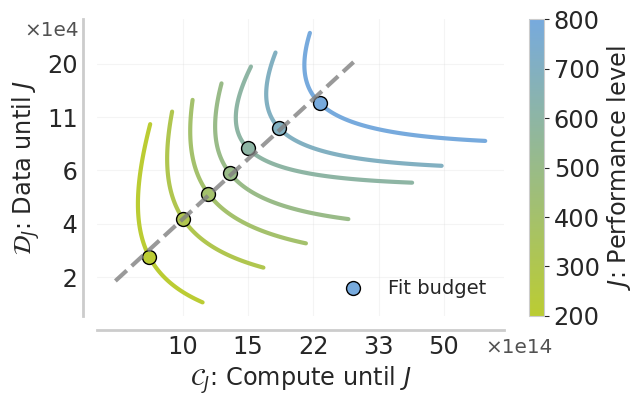

In [ ]:
dmc_delta = 1e10

(
    dmc_min_points_compute,
    dmc_min_points_data,
    dmc_min_points_utd,
) = plot_compute_data_isoperformance(
    dmc_ours_fits,
    dmc_ours_median_median,
    dmc_n_thresholds,
    dmc_utds,
    dmc_sweep_path,
    dmc_model_size,
    dmc_delta,
    (10e14, 50e14),
    (2e4, 20e4),
    '1e14',
    '1e4',
)

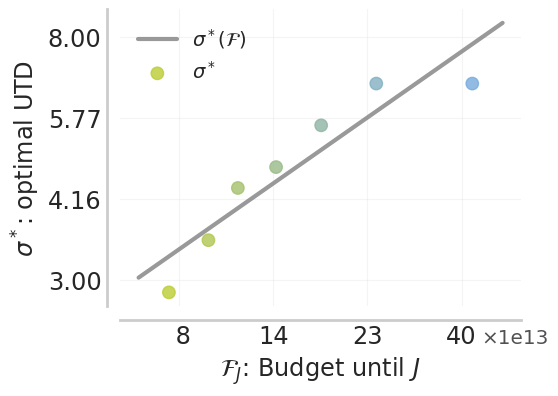

In [ ]:
def plot_budget_extrapolation(
    min_points_compute,
    min_points_data,
    min_points_utd,
    delta,
    n_thresholds,
    xlim,
    ylim,
    xscale: str,
):
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(496.0 / 192 * 2, 369.6 / 192 * 2)

    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
    n_colors = n_thresholds
    colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

    x_min, x_max = xlim
    y_min, y_max = ylim

    # Fit line in log space
    min_points_budget = min_points_compute + delta * min_points_data
    fit_points = [0, 1, 2, 3, 4, 5, 6]
    coeffs = np.polyfit(np.log10(min_points_budget[fit_points]), np.log10(min_points_utd[fit_points]), 1)
    # Generate points for the ours line
    budget_range = np.log10(min(min_points_budget)), np.log10(max(min_points_budget))
    budget_line = np.logspace(
        budget_range[0] - 0.1 * (budget_range[1] - budget_range[0]),
        budget_range[1] + 0.1 * (budget_range[1] - budget_range[0]),
        100,
    )
    utd_line = 10 ** (coeffs[0] * np.log10(budget_line) + coeffs[1])
    plt.plot(budget_line, utd_line, color='gray', linewidth=3, alpha=0.8, label='$\sigma^*(\mathcal{F})$')
    plt.scatter(
        min_points_budget[:], min_points_utd[:], marker='o', color=colors[:], label='$\sigma^*$', alpha=0.8, s=80
    )

    plt.xscale('log')
    plt.yscale('log')
    axs.legend(prop={'size': 14}, ncol=1, frameon=False)

    x = np.logspace(np.log10(x_min), np.log10(x_max), num=4, dtype=int)
    xlabels = ['%2.f' % (y / float(xscale)) for y in x]
    axs.xaxis.set_major_locator(plt.FixedLocator(x))
    axs.xaxis.set_minor_locator(plt.NullLocator())
    axs.set_xticks(x, xlabels, size=14.5)

    yticks = np.logspace(np.log10(y_min), np.log10(y_max), num=4)
    ylabels = ['%2.2f' % (y) for y in yticks]
    axs.yaxis.set_major_locator(plt.FixedLocator(yticks))
    axs.yaxis.set_minor_locator(plt.NullLocator())
    axs.set_yticks(yticks, ylabels, size=14.5)

    plot_utils._annotate_and_decorate_axis(
        axs,
        xlabel='$\mathcal{F}_J$: Budget until $J$',
        ylabel='$\sigma^*$: optimal UTD',
        labelsize='xx-large',
        ticklabelsize='xx-large',
        grid_alpha=0.2,
        legend=False,
    )

    plt.text(
        1.07,
        -0.14,
        f'×{xscale}',
        transform=axs.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize='x-large',
        alpha=0.8,
    )
    plt.show()


plot_budget_extrapolation(
    gym_min_points_compute,
    gym_min_points_data,
    gym_min_points_utd,
    gym_delta,
    gym_n_thresholds,
    (8e13, 40e13),
    (3, 8),
    '1e13',
)

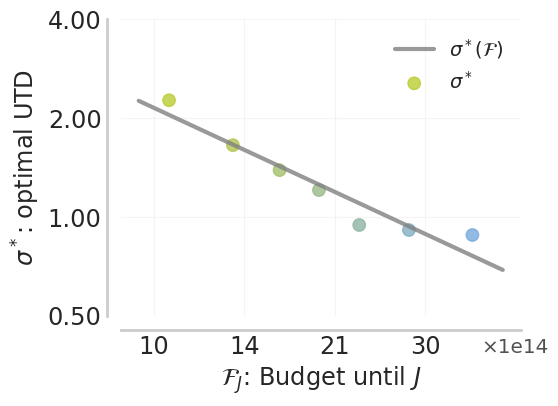

In [ ]:
plot_budget_extrapolation(
    dmc_min_points_compute,
    dmc_min_points_data,
    dmc_min_points_utd,
    dmc_delta,
    dmc_n_thresholds,
    (1e15, 3e15),
    (0.5, 4),
    '1e14',
)